In [22]:
import math
from pickletools import optimize
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



msft = yf.Ticker("MSFT")
df = msft.history(start ='2000-01-01' , end = '2019-01-01')
df.to_csv('../CSV/msft.csv')

df = pd.read_csv('../CSV/msft.csv')

#data set for training
data = df.filter(['Close'])
dataset = data.values

#scales data into 1-0
scaler = MinMaxScaler(feature_range=(0,1))
scaler_data = scaler.fit_transform(dataset)

#training sets 
train_size = int(df.shape[0] * 0.8)
train_set = scaler_data[0: train_size, :]

x_train = []
y_train = []

for i in range(60, train_size):
    x_train.append(train_set[i-60: i, 0])
    y_train.append(train_set[i,0])



x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size = 1, epochs = 1)





3763/3763 [==============================] - 154s 40ms/step - loss: 1.5756e-04


6.168005819599998


/var/folders/w_/bcbslvsd4cz_kwppplndj7gc0000gn/T/ipykernel_18957/1784211440.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


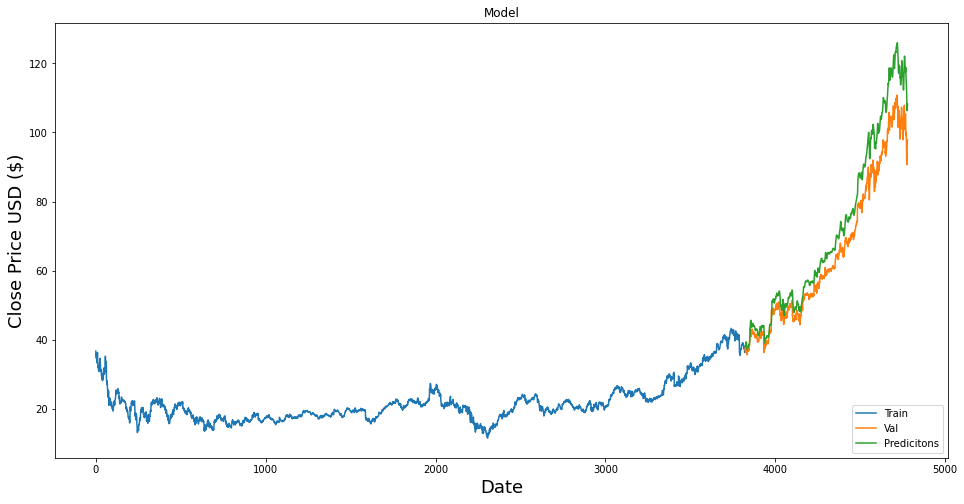

<Figure size 432x288 with 0 Axes>

In [23]:
test_data = scaler_data[train_size -60:, :]

x_test = []
y_test = dataset[train_size:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean( predictions - y_test)**2)

print(rmse)

train = data[:train_size]
valid = data[train_size:]

valid['Predictions'] = predictions

#Visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train["Close"])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predicitons'], loc = 'lower right')
plt.show()
plt.savefig("../plots/visualize.png")



In [24]:


apple = yf.Ticker("AAPL")
df = apple.history(start ='2015-01-01', end = '2016-01-01')
new_df = df.filter(['Close'])
data = new_df[-60:].values

data_scaled = scaler.transform(data)
apple_60_predictions = []

for i in range(120):
    x_test = []
    x_test.append(data_scaled)
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    pred_price = model.predict(x_test)
    data_scaled= np.concatenate((data_scaled[1:], [[pred_price[0][0]]]))
    pred_price = scaler.inverse_transform(pred_price)
    apple_60_predictions.append(pred_price[0][0])

df = apple.history(start ='2016-01-01')
print("Predictions" , "Actual")
for i in range(120):
    print(apple_60_predictions[i],"    ", df['Close'][i] , end = "  ")
    print(abs(apple_60_predictions[i] - df['Close'][i]))





Predictions Actual
24.573063      24.185047149658203  0.3880157470703125
24.513678      23.578981399536133  0.9346961975097656
24.488867      23.11754608154297  1.3713207244873047
24.475046      22.141889572143555  2.3331565856933594
24.464823      22.258960723876953  2.205862045288086
24.455685      22.6193904876709  1.836294174194336
24.44665      22.94767189025879  1.4989776611328125
24.43725      22.357681274414062  2.079568862915039
24.42723      22.846662521362305  1.5805683135986328
24.41643      22.29798698425293  2.1184425354003906
24.404753      22.19009780883789  2.2146549224853516
24.39214      22.219942092895508  2.1721973419189453
24.378553      22.10744857788086  2.2711048126220703
24.363981      23.282838821411133  1.0811424255371094
24.348412      22.828296661376953  1.5201148986816406
24.331844      22.954557418823242  1.3772869110107422
24.314274      21.4462947845459  2.867979049682617
24.295702      21.600099563598633  2.6956024169921875
24.276121      22.346200942

120 1609


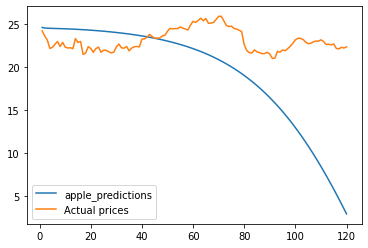

In [30]:
index = []
for i in range(120):
    index.append(i+1)

print(len(apple_60_predictions), df.shape[0])

plt.plot(index, apple_60_predictions , label = 'apple_predictions')
plt.plot(index , df['Close'][:120] , label = 'Actual prices')
plt.legend()
plt.show()
